El siguiente código presenta un tratamiento y análisis de transporte de pasajeros de transporte terrestre en Colombia desde el años 2019.
La data proviene del recurso público https://www.datos.gov.co/Transporte/Operaci-n-de-pasajeros-y-despacho-de-veh-culos-en-/eh75-8ah6, y el documento de códificación de municipios desde https://geoportal.dane.gov.co/geovisores/territorio/consulta-divipola-division-politico-administrativa-de-colombia/

La explicación de observaciones se evidencia en puntos específicos y después de algunas gráficas realizadas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import requests
from io import StringIO
from openpyxl import load_workbook
from io import BytesIO

# **Exportación y preprocesamiento de datos**

Antes de comenzar con el trabajo de análisis se implementará un primer tratamiento que constará de agregar los datos de DIVIPOLA extraidos del DANE al archivo de operación terrestre extraido de Datos.gov

In [2]:
#Datos directamente desde la API
# Definir la URL base
base_url = "https://www.datos.gov.co/resource/eh75-8ah6.csv"
response = requests.get(base_url)


# Obtener el año actual
current_year = pd.to_datetime("today").year

# Crear una lista para almacenar los DataFrames por año
dataframes = []

# Iterar a través de los años desde 2019 hasta el año actual
for year in range(2019, current_year + 1):
    # Construir la URL para el año actual
    year_url = f"{base_url}?$where=fecha_despacho between '{year}-01-01T00:00:00' and '{year}-12-31T00:00:00'&$limit=10000000"
    # Realizar una solicitud GET a la URL y obtener el contenido del CSV
    response = requests.get(year_url)
    
    # Crear un DataFrame a partir del contenido del CSV
    df = pd.read_csv(StringIO(response.text))
    
    # Agregar el DataFrame a la lista
    dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)
data.columns = map(str.upper, data.columns)
# Ahora tienes todos los datos en full_data
print(data.head())

         TERMINAL CLASE_VEHICULO NIVEL_SERVICIO MUNICIPIO_ORIGEN_RUTA  \
0  T.T. DE MAICAO            BUS           LUJO                 44430   
1  T.T. DE MAICAO            BUS           LUJO                 44430   
2  T.T. DE MAICAO            BUS           LUJO                 44430   
3  T.T. DE MAICAO            BUS           LUJO                 44430   
4  T.T. DE MAICAO            BUS           LUJO                 44430   

  MUNICIPIO_DESTINO_RUTA           FECHA_DESPACHO HORA_DESPACHO TIPO_DESPACHO  \
0                   5001  2019-01-01T00:00:00.000            14        ORIGEN   
1                  13001  2019-01-01T00:00:00.000            11        ORIGEN   
2                   8001  2019-01-01T00:00:00.000            15        ORIGEN   
3                   8001  2019-01-01T00:00:00.000            16        ORIGEN   
4                  13001  2019-01-01T00:00:00.000            15        ORIGEN   

  DESPACHOS PASAJEROS  
0         1        16  
1         1        10  
2 

In [3]:
#Revisar cantidad de datos extraidos y otras distribuciones
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20233225 entries, 0 to 20233224
Data columns (total 10 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   TERMINAL                object
 1   CLASE_VEHICULO          object
 2   NIVEL_SERVICIO          object
 3   MUNICIPIO_ORIGEN_RUTA   object
 4   MUNICIPIO_DESTINO_RUTA  object
 5   FECHA_DESPACHO          object
 6   HORA_DESPACHO           object
 7   TIPO_DESPACHO           object
 8   DESPACHOS               object
 9   PASAJEROS               object
dtypes: object(10)
memory usage: 1.5+ GB


In [4]:
print(data.dtypes) #Revisar tipo de datos desde .json

TERMINAL                  object
CLASE_VEHICULO            object
NIVEL_SERVICIO            object
MUNICIPIO_ORIGEN_RUTA     object
MUNICIPIO_DESTINO_RUTA    object
FECHA_DESPACHO            object
HORA_DESPACHO             object
TIPO_DESPACHO             object
DESPACHOS                 object
PASAJEROS                 object
dtype: object


In [5]:
#Convertir datos con base a requerimientos y revisar nuevamente
data['MUNICIPIO_ORIGEN_RUTA'] = data['MUNICIPIO_ORIGEN_RUTA'].astype(int)
data['MUNICIPIO_DESTINO_RUTA'] = data['MUNICIPIO_DESTINO_RUTA'].astype(int)
data['HORA_DESPACHO'] = data['HORA_DESPACHO'].astype(int)
data['DESPACHOS'] = data['DESPACHOS'].astype(int)
data['PASAJEROS'] = data['PASAJEROS'].astype(int)

#Revisar conversiones 
print(data.dtypes)

TERMINAL                  object
CLASE_VEHICULO            object
NIVEL_SERVICIO            object
MUNICIPIO_ORIGEN_RUTA      int32
MUNICIPIO_DESTINO_RUTA     int32
FECHA_DESPACHO            object
HORA_DESPACHO              int32
TIPO_DESPACHO             object
DESPACHOS                  int32
PASAJEROS                  int32
dtype: object


In [6]:
#Leer documento de despacho de pasajeros terrestres y visualizar los primeros renglones de este documento

#data = pd.read_csv('D:\Descargas\Operaci_n_de_pasajeros_y_despacho_de_veh_culos_en_la_modalidad_de_transporte_de_pasajeros_por_carretera1.csv', encoding="utf-8")

#Debido a un dato de tipo incorrecto sobre una de las columnas en esta versión del archivo, es necesario implementar
#la conversión de dato antes de continuar con el proceso de análisis, la conversión directa con el reemplazo genera problemas
#al querer realizar operaciones matemáticas sobre este campo
#def replace_comma(value):
#    if isinstance(value, str) and ',' in value and '.' not in value:
#        return float(value.replace(',', ''))
#    return value  #Al requerir ser string para reemplazo de carácteres no númericos, se implementan los reemplazos para volver a formato numérico ideal#

#data['PASAJEROS'] = data['PASAJEROS'].apply(replace_comma)
#data['PASAJEROS'] = data['PASAJEROS'].astype(int)
#print(data.dtypes)
#data.head()

In [7]:
#Poseemos un documento con la códificación interna de los municipios y departamentos del país, el cual podemos implementar
#y realizar análisis con mayor claridad y personalización

#Leer documento de excel que contiene códigos de municipios y poder transformar coincidencia en el documento anterior
#municipios_nombre = pd.read_excel('d:\Descargas\DIVIPOLA_Municipios.xlsx', sheet_name="Hoja1")
#municipios_nombre.head()

url = "https://geoportal.dane.gov.co/descargas/divipola/DIVIPOLA_Municipios.xlsx"

response = requests.get(url)
if response.status_code == 200:
    with BytesIO(response.content) as buffer:
        workbook = load_workbook(buffer)
        sheet = workbook.active

        # Encuentra la primera fila que contiene datos y finaliza al final del contenido deseado
        first_data_row = 11
        last_row = 1132

        # Convierte la hoja de Excel en un DataFrame de Pandas, omitiendo las filas anteriores
        municipios_nombre = pd.DataFrame(sheet.iter_rows(values_only=True, min_row=first_data_row, max_row=last_row))
        
        # Asegúrate de que los encabezados de columna se configuren adecuadamente si no están en la primera fila.

        # Ahora puedes trabajar con el DataFrame df
else:
    print(f"Failed to download Excel file. Status code: {response.status_code}")

# Después de crear el DataFrame df
municipios_nombre.columns = municipios_nombre.iloc[0]

# Luego, elimina la primera fila, ya que se ha convertido en el título de las columnas
municipios_nombre = municipios_nombre.iloc[1:]

#En este primer formato de extracción existen columnas con nombre duplicado
#Así que es necesario renombrarla correctamente para la unión con el otro dataframe
# Encuentra las columnas duplicadas
duplicadas = municipios_nombre.columns[municipios_nombre.columns.duplicated()].tolist()

# Renombra las columnas duplicadas de manera única
for duplicada in duplicadas:
    indices = [i for i, col in enumerate(municipios_nombre.columns) if col == duplicada]
    for i, index in enumerate(indices):
        if i > 0:
            municipios_nombre.columns.values[index] = f"{duplicada}_{i}"

# Ahora puedes renombrar las columnas como desees
municipios_nombre = municipios_nombre.rename(columns={"Código " : "CódigoDepartamento",
                                                      "Nombre" : "NombreDepartamento",
                                                      "Código _1" : "CódigoMunicipio",
                                                      "Nombre_1" : "NombreMunicipio"})

municipios_nombre["CódigoMunicipio"] = municipios_nombre["CódigoMunicipio"].astype(int)

municipios_nombre.head(20)


,CódigoDepartamento,NombreDepartamento,CódigoMunicipio,NombreMunicipio,None,LATITUD,LONGITUD,None_1
1,05,ANTIOQUIA,5001,MEDELLÍN,Municipio,6.25759,-75.611031,None
2,05,ANTIOQUIA,5002,ABEJORRAL,Municipio,5.803728,-75.438474,None
3,05,ANTIOQUIA,5004,ABRIAQUÍ,Municipio,6.627569,-76.085978,None
4,05,ANTIOQUIA,5021,ALEJANDRÍA,Municipio,6.365534,-75.090597,None
5,05,ANTIOQUIA,5030,AMAGÁ,Municipio,6.032922,-75.708003,None
6,05,ANTIOQUIA,5031,AMALFI,Municipio,6.977789,-74.981239,None
7,05,ANTIOQUIA,5034,ANDES,Municipio,5.604993,-75.941284,None
8,05,ANTIOQUIA,5036,ANGELÓPOLIS,Municipio,6.12143,-75.71595,None
9,05,ANTIOQUIA,5038,ANGOSTURA,Municipio,6.861499,-75.358316,None
10,05,ANTIOQUIA,5040,ANORÍ,Municipio,7.193111,-75.10849,None


In [8]:
print(municipios_nombre.dtypes)

0
CódigoDepartamento    object
NombreDepartamento    object
CódigoMunicipio        int32
NombreMunicipio       object
None                  object
LATITUD               object
LONGITUD              object
None_1                object
dtype: object


In [9]:
# Realizar el mapeo del código con el municipio y departamento
codigo_municipio_map = dict(zip(municipios_nombre['CódigoMunicipio'], municipios_nombre['NombreMunicipio']))
codigo_departamento_map = dict(zip(municipios_nombre['CódigoMunicipio'], municipios_nombre['NombreDepartamento']))

#print(codigo_departamento_map)
#print(codigo_municipio_map)

#Agregar nombre al documento de trasnporte terrestre con la coincidencia de códigos
data['MUNICIPIO_DESTINO'] = data['MUNICIPIO_DESTINO_RUTA'].map(codigo_municipio_map)
data['DEPARTAMENTO_DESTINO'] = data['MUNICIPIO_DESTINO_RUTA'].map(codigo_departamento_map)
data['MUNICIPIO_ORIGEN'] = data['MUNICIPIO_ORIGEN_RUTA'].map(codigo_municipio_map)
data['DEPARTAMENTO_ORIGEN'] = data['MUNICIPIO_ORIGEN_RUTA'].map(codigo_departamento_map)

#Muestra de la nueva transformación
data.head()

,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,MUNICIPIO_ORIGEN_RUTA,MUNICIPIO_DESTINO_RUTA,FECHA_DESPACHO,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS,MUNICIPIO_DESTINO,DEPARTAMENTO_DESTINO,MUNICIPIO_ORIGEN,DEPARTAMENTO_ORIGEN
0,T.T. DE MAICAO,BUS,LUJO,44430,5001,2019-01-01T00:00:00.000,14,ORIGEN,1,16,MEDELLÍN,ANTIOQUIA,MAICAO,LA GUAJIRA
1,T.T. DE MAICAO,BUS,LUJO,44430,13001,2019-01-01T00:00:00.000,11,ORIGEN,1,10,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA
2,T.T. DE MAICAO,BUS,LUJO,44430,8001,2019-01-01T00:00:00.000,15,ORIGEN,1,10,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
3,T.T. DE MAICAO,BUS,LUJO,44430,8001,2019-01-01T00:00:00.000,16,ORIGEN,1,14,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
4,T.T. DE MAICAO,BUS,LUJO,44430,13001,2019-01-01T00:00:00.000,15,ORIGEN,1,16,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA


Antes de continuar, debido al contexto de Python es necesario convertir correctamente algunos campos que desde el origen pueden presentarnos problema en el desarrollo de análisis

In [10]:
#Es necesario agregar un paso extra para convertir correctamente el campo de fecha al fromato deseado
#ya que la hora presente en este campo está erronéa a comparación de HORA DESPACHO
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['FECHA_DESPACHO'] = data['FECHA_DESPACHO'].dt.date
data.head()
data.to_csv('Transporte Pasajeros 2019-2023.csv') #habilitar opción para descargar un csv "limpio" e implementarse en herramientas de visualización

In [11]:
#Limpieza de datos rehundantes en el conjunto
#Eliminar las columnas originales de municipios de origen y municipios de destino del archivo
columnas_a_eliminar = ['MUNICIPIO_ORIGEN_RUTA', 'MUNICIPIO_DESTINO_RUTA']
data.drop(columnas_a_eliminar, axis=1, inplace=True)
data.head()

,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,FECHA_DESPACHO,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS,MUNICIPIO_DESTINO,DEPARTAMENTO_DESTINO,MUNICIPIO_ORIGEN,DEPARTAMENTO_ORIGEN
0,T.T. DE MAICAO,BUS,LUJO,2019-01-01,14,ORIGEN,1,16,MEDELLÍN,ANTIOQUIA,MAICAO,LA GUAJIRA
1,T.T. DE MAICAO,BUS,LUJO,2019-01-01,11,ORIGEN,1,10,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA
2,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,10,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
3,T.T. DE MAICAO,BUS,LUJO,2019-01-01,16,ORIGEN,1,14,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
4,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,16,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA


In [12]:
#Revisamos nuevamente el tipo de dato de cada columna y verificamos el tipo de las 2 columnas númericas de mayor uso
#Pasajeros y Despachos, pues son las principales referencias para el problema
print(data.dtypes)

TERMINAL                object
CLASE_VEHICULO          object
NIVEL_SERVICIO          object
FECHA_DESPACHO          object
HORA_DESPACHO            int32
TIPO_DESPACHO           object
DESPACHOS                int32
PASAJEROS                int32
MUNICIPIO_DESTINO       object
DEPARTAMENTO_DESTINO    object
MUNICIPIO_ORIGEN        object
DEPARTAMENTO_ORIGEN     object
dtype: object


# **Análisis de datos**

Una vez con los arreglos aplicados, se puede empezar a trabajar con la parte exploratoria y descriptiva de los datos extraídos

In [13]:
#Observamos una estadística descriptiva sobre los datos en las variables más importantes
data.describe()

,HORA_DESPACHO,DESPACHOS,PASAJEROS
count,2.023322e+07,2.023322e+07,2.023322e+07
mean,1.201241e+01,1.915018e+00,1.515606e+01
std,5.091754e+00,2.184741e+00,2.256372e+01
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,8.000000e+00,1.000000e+00,4.000000e+00
50%,1.200000e+01,1.000000e+00,8.000000e+00
75%,1.600000e+01,2.000000e+00,1.800000e+01
max,2.300000e+01,2.980000e+02,3.159000e+03


In [14]:
#Al observar que hay pasajeros con un valor mínimo de 0, son valores innecesarios dentro del dataframe en el contexto de análisis.
#Por cual se contará la cantidad de filas con este valor y luego se eliminarán estas.
Pasajeros0 = (data['PASAJEROS']==0).sum()
print('Cantidad de viajes con 0 parasajeros', Pasajeros0)
filastotales = data.shape[0]
print('Tamaño total del conjunto', filastotales)
print('razón pasajeros 0 sobre total', (Pasajeros0/filastotales))

Cantidad de viajes con 0 parasajeros 2590292
Tamaño total del conjunto 20233225
razón pasajeros 0 sobre total 0.12802170687075343


In [15]:
#Explicación de razón de datos 0 del documento
razon_en_porcentaje = round((Pasajeros0/filastotales)*100, 2)
print(f'Si bien es un alto número de regitros con pasajeros 0, marca sólo un {razon_en_porcentaje}% del total de estos, por lo cual se pueden eliminar estos valores del connjunto general de datos')

Si bien es un alto número de regitros con pasajeros 0, marca sólo un 12.8% del total de estos, por lo cual se pueden eliminar estos valores del connjunto general de datos


In [16]:
#Estos registros no son de gran relevancia para el caso, dado que el contexto PB se enfoca sobre el transporte de pasajeros entre ciudades
data = data.drop(data[data['PASAJEROS']==0].index)
data.shape[0]
data.head()

,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,FECHA_DESPACHO,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS,MUNICIPIO_DESTINO,DEPARTAMENTO_DESTINO,MUNICIPIO_ORIGEN,DEPARTAMENTO_ORIGEN
0,T.T. DE MAICAO,BUS,LUJO,2019-01-01,14,ORIGEN,1,16,MEDELLÍN,ANTIOQUIA,MAICAO,LA GUAJIRA
1,T.T. DE MAICAO,BUS,LUJO,2019-01-01,11,ORIGEN,1,10,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA
2,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,10,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
3,T.T. DE MAICAO,BUS,LUJO,2019-01-01,16,ORIGEN,1,14,BARRANQUILLA,ATLÁNTICO,MAICAO,LA GUAJIRA
4,T.T. DE MAICAO,BUS,LUJO,2019-01-01,15,ORIGEN,1,16,CARTAGENA DE INDIAS,BOLÍVAR,MAICAO,LA GUAJIRA


In [17]:
#Para simplificar el proceso de agrupación de las variables de Pasajero y Despacho se creará la siguiente variable
def grupo_por_columna(dt, columna_agrupada):
    #   Agrupar datos en resumen de suma
    agrupacion = dt.groupby(columna_agrupada).agg({'PASAJEROS': 'sum', 'DESPACHOS': 'sum'}).reset_index()
    return agrupacion

In [18]:
#La agrupación de las 2 variables principales representan cantidades grandes para el formato de Python y Jupyter
#Entonces se agrega la conjetura a etiquetas de los gráficos a generar en las siguientes líneas
def formato_ejes(x, pos):
    return f'{int(x/1e6)}M'


In [19]:
#Adicional se calculará el total general de Pasajeros y Despachos para contemplar propociones de las agrupaciones a generar
total_pasajeros = data['PASAJEROS'].sum()
total_despachos = data['DESPACHOS'].sum()
pasajero_prom_por_despacho = (total_pasajeros/total_despachos).round(2)

print('Total Pasajeros:', total_pasajeros)
print('Total Despachos:', total_despachos)
print('Pasajero promedio por Despacho:', pasajero_prom_por_despacho)

Total Pasajeros: 306655941
Total Despachos: 34413976
Pasajero promedio por Despacho: 8.91


### Histórico de despachos y pasajeros por mes-año

Tomaremos de incio, análizar el comportamiento histórico de la data registrada

    MES-AÑO  PASAJEROS  DESPACHOS  Variación Despachos(%)  \
0   2019-01      54963       3299                     NaN   
1   2019-02      19156       1466                  -55.56   
2   2019-04        885         54                  -96.32   
3   2021-01    4595204     722460              1337788.89   
4   2021-02    4306643     690112                   -4.48   
5   2021-03    5478071     805130                   16.67   
6   2021-04    4321312     658807                  -18.17   
7   2021-05    2166088     348611                  -47.08   
8   2021-06    4590585     663314                   90.27   
9   2021-07    5812707     791128                   19.27   
10  2021-08    6374594     823133                    4.05   
11  2021-09    6286538     806589                   -2.01   
12  2021-10    7249212     838779                    3.99   
13  2021-11    7092753     818891                   -2.37   
14  2021-12    9292568     923886                   12.82   
15  2022-01    8523410  

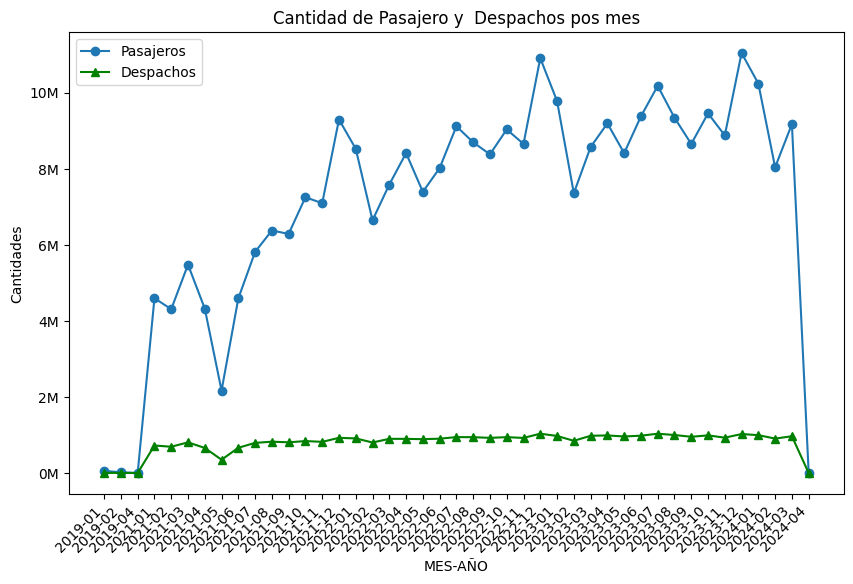

In [20]:
#Primero será necesario agrupar los datos por mes-año según Fecha Despacho
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['MES-AÑO'] = data['FECHA_DESPACHO'].dt.to_period('M')
data_agrupada = grupo_por_columna(data, 'MES-AÑO')


data_agrupada['Variación Despachos(%)'] = (data_agrupada['DESPACHOS'].pct_change() * 100).round(2)
data_agrupada['Variación Pasajeros (%)'] = (data_agrupada['PASAJEROS'].pct_change() * 100).round(2)

print(data_agrupada)
print(data_agrupada)
data_agrupada['MES-AÑO'] = data_agrupada['MES-AÑO'].astype(str)

#Graficar los datos
plt.figure(figsize=(10,6))
ax = plt.gca()
plt.plot(data_agrupada['MES-AÑO'], data_agrupada['PASAJEROS'], label = 'Pasajeros', marker = 'o')
plt.plot(data_agrupada['MES-AÑO'], data_agrupada['DESPACHOS'], label = 'Despachos', marker = '^', color='green')
ax.yaxis.set_major_formatter(FuncFormatter(formato_ejes))
plt.xlabel('MES-AÑO')
plt.ylabel('Cantidades')
plt.title('Cantidad de Pasajero y  Despachos pos mes')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

Ya que estamos observando la data con base en un rango de 4 años, es interesante poder observar los máximos y mínimos de este, aunque de entrada se observa que los datos del último mes registrado del 2024 (año actual) aun están incompletos lo ideal es rescatar el menor valor sin contemplar este mes sin finalizar. Gracias a la gráfica anterior, el patrón de ambos valores es el mismo, por lo cual se observará el mínimo y máximo de ambos valores independientes en los mismos meses.

In [21]:
#Contempletar datos agrupados sin el último mes en cuestión
data_agrupada_sin_último_mes = data_agrupada.iloc[:-1]

# mes con el menor y mayor cantidad de despachos
mes_menor_despachos = data_agrupada_sin_último_mes.loc[data_agrupada_sin_último_mes['DESPACHOS'].idxmin()]
mes_mayor_despachos = data_agrupada.loc[data_agrupada['DESPACHOS'].idxmax()]

# Extraer los pasajeros según el mínimo anterior
pasajeros_menor_despacho = mes_menor_despachos['PASAJEROS']
pasajeros_mayor_despacho = mes_mayor_despachos['PASAJEROS']

#Imprimir y observar resúltados
print(f"Mes con el mínimo general: {mes_menor_despachos['MES-AÑO']}, Despachos: {mes_menor_despachos['DESPACHOS']}, Pasajeros: {pasajeros_menor_despacho}")
print(f"Mes con el máximo general: {mes_mayor_despachos['MES-AÑO']}, Despachos: {mes_mayor_despachos['DESPACHOS']}, Pasajeros: {pasajeros_mayor_despacho}")


Mes con el mínimo general: 2019-04, Despachos: 54, Pasajeros: 885
Mes con el máximo general: 2022-12, Despachos: 1033279, Pasajeros: 10905662


De entrada, el histórico, que nos muestra datos desde los últimos 4 meses del 2019 hasta el mes casi actual del presente año. Se evidencia que la pandemía afectó en gran medida el transporte terrestre de pasajeros. Gracias el máximo y mínimo, se observa que no se ha logrado romper el máximo histórico después de pandemia, lo cuál parece que el viaje a través de terminales terrestres aun requiere esfuerzos para volver a obtener alto tráfico, o existen más autos familiares en carreteras nacionales. No obstante, el año 2023 comenzó casi acercandose a este máximo hitórico, lo cuál debió incrementar esperanzas en las compañías de transporte sobre la expectativas de viaje para este año.

Adicional, como se mencionó antes, el patrón de demanda y oferta de transporte es cohorente y sugiere que se abarca en mejor medida en todo el tiempo recorrido

In [22]:
#Correlación Despachos-Pasajeros
corr = round(data['PASAJEROS'].corr(data['DESPACHOS']), 4)

print(f'Las 2 variables principales entregan una correlación de {corr} lo cual implica que tienden a ser directamente proporcionales entre sí')

Las 2 variables principales entregan una correlación de 0.6465 lo cual implica que tienden a ser directamente proporcionales entre sí


### Variación anual Despachos y Pasajeros
Ya vista la tendencia general en cada uno de los meses presentes en el conjunto de datos, podemos entrar en más detalle sobre esto, observando ésta a nivel de Departamento de Origen, en cuestión anual

In [23]:
#Agrupar la data por fecha de despacho considerando únicamente el año
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['AÑO'] = data['FECHA_DESPACHO'].dt.to_period('Y')

#Se agrupa y se presenta en tabla, agregando la varión año a año para cada variable
tendencia_anual_por_departamento = grupo_por_columna(data, ['DEPARTAMENTO_ORIGEN', 'AÑO'])
tendencia_anual_por_departamento['Pasajeros YoY'] = (tendencia_anual_por_departamento.groupby('DEPARTAMENTO_ORIGEN')['PASAJEROS'].pct_change()*100).round(2)
tendencia_anual_por_departamento['Despachos YoY'] = (tendencia_anual_por_departamento.groupby('DEPARTAMENTO_ORIGEN')['DESPACHOS'].pct_change()*100).round(2)
print(tendencia_anual_por_departamento)

#En este punto es necesario indagar en cómo evitar el resultado de variación para años no consecutivos

    DEPARTAMENTO_ORIGEN   AÑO  PASAJEROS  DESPACHOS  Pasajeros YoY  \
0             ANTIOQUIA  2021    9458314    1115572            NaN   
1             ANTIOQUIA  2022   12989999    1248182          37.34   
2             ANTIOQUIA  2023   14585711    1314276          12.28   
3             ANTIOQUIA  2024    3277110     270009         -77.53   
4                ARAUCA  2021       2360        278            NaN   
..                  ...   ...        ...        ...            ...   
104              TOLIMA  2024    1091224     113851         -75.29   
105     VALLE DEL CAUCA  2021    9973877    1334413            NaN   
106     VALLE DEL CAUCA  2022   15382087    1657128          54.22   
107     VALLE DEL CAUCA  2023   14999614    1638318          -2.49   
108     VALLE DEL CAUCA  2024    3663404     394556         -75.58   

     Despachos YoY  
0              NaN  
1            11.89  
2             5.30  
3           -79.46  
4              NaN  
..             ...  
104         

In [24]:
#Adicional podemos observar la tendencia mensual para cada departamento de origen
data['FECHA_DESPACHO'] = pd.to_datetime(data['FECHA_DESPACHO'])
data['MES'] = data['FECHA_DESPACHO'].dt.to_period('M')


#Calcular la variación interanual de las variables por Departamento de Origen
tendencia_anual_por_departamento_mes = grupo_por_columna(data, ['DEPARTAMENTO_ORIGEN', 'MES'])
tendencia_anual_por_departamento_mes['Pasajeros MoM'] = (tendencia_anual_por_departamento_mes.groupby('DEPARTAMENTO_ORIGEN')['PASAJEROS'].pct_change()*100).round(2)
tendencia_anual_por_departamento_mes['Despachos MoM'] = (tendencia_anual_por_departamento_mes.groupby('DEPARTAMENTO_ORIGEN')['DESPACHOS'].pct_change()*100).round(2)
print(tendencia_anual_por_departamento_mes)

#Indagar sobre el resultado para varaición en meses no consecutivos

     DEPARTAMENTO_ORIGEN      MES  PASAJEROS  DESPACHOS  Pasajeros MoM  \
0              ANTIOQUIA  2021-01     659283      93215            NaN   
1              ANTIOQUIA  2021-02     630285      89571          -4.40   
2              ANTIOQUIA  2021-03     778790     102068          23.56   
3              ANTIOQUIA  2021-04     517836      73993         -33.51   
4              ANTIOQUIA  2021-05     505679      76372          -2.35   
...                  ...      ...        ...        ...            ...   
1065     VALLE DEL CAUCA  2023-12    1233425     119883          28.30   
1066     VALLE DEL CAUCA  2024-01    1281536     130005           3.90   
1067     VALLE DEL CAUCA  2024-02    1119626     126981         -12.63   
1068     VALLE DEL CAUCA  2024-03    1261850     137555          12.70   
1069     VALLE DEL CAUCA  2024-04        392         15         -99.97   

      Despachos MoM  
0               NaN  
1             -3.91  
2             13.95  
3            -27.51  
4

En teoría, gracias a que los datos del 2019 no abarcan el año completo, la variación observada para el 2020 representaría una cambio alto, no obstante lo sucedido en este año mantuvo ambas variables en una punto constante para ambos años en la mayoría de departamentos. Así mismo, en algunos de estos los despachos mantuvieron cierta normalidad en algunos meses del segundo año. No obstante, la recuperación en el transporte terrestre es observables desde el segundo semestre del 2021 donde las restricciones de pandemia empezaron a obtener mayor flexibilidad.

Tabla por hora despacho:
 HORA_DESPACHO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  PORCENTAJE_DESPACHOS
             0    2477612     168052                  0.81                  0.49
             1    1931666     143822                  0.63                  0.42
             2    2031079     156768                  0.66                  0.46
             3    2700538     252606                  0.88                  0.73
             4    5384715     676466                  1.76                  1.97
             5   10094207    1378054                  3.29                  4.00
             6   14650571    2002232                  4.78                  5.82
             7   15243251    2128978                  4.97                  6.19
             8   16557424    2224086                  5.40                  6.46
             9   17233135    2237274                  5.62                  6.50
            10   18453897    2298284                  6.02                  6.68
   

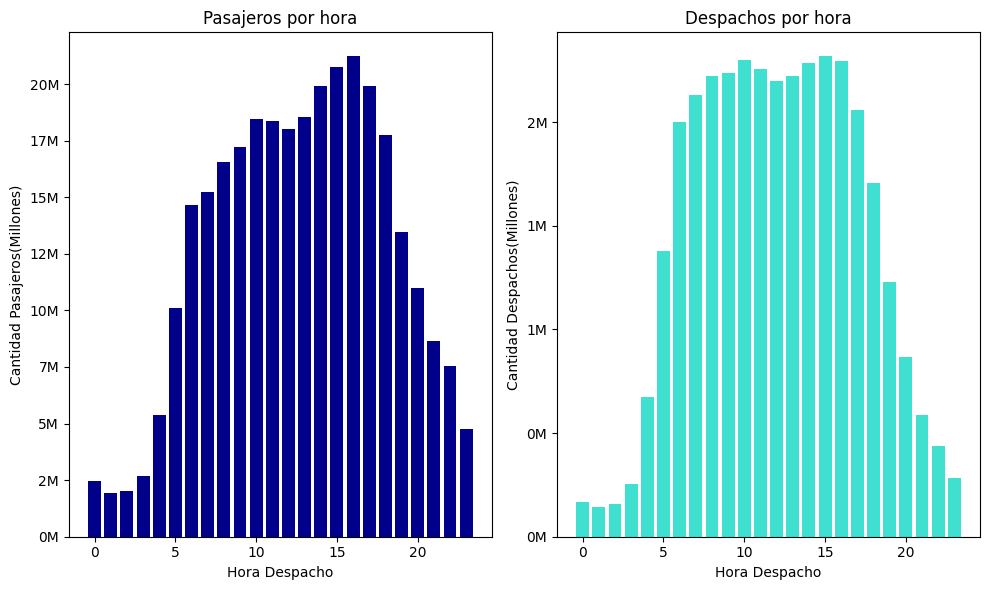

In [25]:
#Ahora observaremos los despachos y pasajeros por horas de despacho
data_por_hora_despacho = grupo_por_columna(data, 'HORA_DESPACHO')
#Calcular las roporciones por hora de despacho
data_por_hora_despacho['PORCENTAJE_PASAJEROS'] = ((data_por_hora_despacho['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_hora_despacho['PORCENTAJE_DESPACHOS'] = ((data_por_hora_despacho['DESPACHOS'] / total_despachos) * 100).round(2)
print('Tabla por hora despacho:')
print(data_por_hora_despacho.to_string(index=False))

#Máximos por Hora de despacho
hora_menos_despachos = data_por_hora_despacho.loc[data_por_hora_despacho['DESPACHOS'].idxmin()]
pasajeros_hora_menos_despachos = hora_menos_despachos['PASAJEROS']
hora_mas_despachos = data_por_hora_despacho.loc[data_por_hora_despacho['DESPACHOS'].idxmax()]
pasajeros_hora_mas_despachos = hora_mas_despachos['PASAJEROS']
print(f"Hora menos Despachos: {hora_menos_despachos['HORA_DESPACHO']}, Despachos:{hora_menos_despachos['DESPACHOS']}, Pasajeros:{pasajeros_hora_menos_despachos}")
print(f"Hora más Despachos: {hora_mas_despachos['HORA_DESPACHO']}, Despachos:{hora_mas_despachos['DESPACHOS']}, Pasajeros:{pasajeros_hora_mas_despachos}")

#Mínimos por hora de despacho
hora_menos_pasajeros = data_por_hora_despacho.loc[data_por_hora_despacho['PASAJEROS'].idxmin()]
despachos_hora_menos_pasajeros = hora_menos_pasajeros['DESPACHOS']
hora_mas_pasajeros = data_por_hora_despacho.loc[data_por_hora_despacho['PASAJEROS'].idxmax()]
despachos_hora_mas_pasajeros = hora_mas_despachos['DESPACHOS']
print(f"Hora menos Pasajeross: {hora_menos_pasajeros['HORA_DESPACHO']}, Pasajeros:{hora_menos_pasajeros['PASAJEROS']}, Despachos:{despachos_hora_menos_pasajeros}")
print(f"Hora más Pasajeros: {hora_mas_pasajeros['HORA_DESPACHO']}, Pasajeros:{hora_mas_pasajeros['PASAJEROS']}, Despachos:{despachos_hora_mas_pasajeros}")

#Gráfica 
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.bar(data_por_hora_despacho['HORA_DESPACHO'], data_por_hora_despacho['PASAJEROS'], color='darkblue')
plt.xlabel('Hora Despacho')
plt.ylabel('Cantidad Pasajeros(Millones)')
plt.title('Pasajeros por hora')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))


plt.subplot(1,2,2)
plt.bar(data_por_hora_despacho['HORA_DESPACHO'], data_por_hora_despacho['DESPACHOS'], color = 'turquoise')
plt.xlabel('Hora Despacho')
plt.ylabel('Cantidad Despachos(Millones)')
plt.title('Despachos por hora')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()

Es curioso ver que a pesar del saber común en el país donde se considera mejor viajar por la noche, la concentración de despachos y pasajeros se distribuye en horas del día, entre las 7a.m. y 6p.m.. Puede deberse a las condiciones de la carreteras en estos momentos o como veremos más adelante el destino de la mayoría de despachos ejecutados por departamento.

Tabla por clase de vehículo
  CLASE_VEHICULO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
1            BUS  145757827   12164372                 47.53   
5       MICROBUS  100970249   12546794                 32.93   
2         BUSETA   28519780    3766149                  9.30   
3      CAMIONETA   22004142    3836076                  7.18   
4        CAMPERO    5288798     800573                  1.72   
0      AUTOMOVIL    4115145    1300012                  1.34   

   PORCENTAJE_DESPACHOS  PASAJERO_PROM_POR_VEHÍCULO  
1                 35.35                       11.98  
5                 36.46                        8.05  
2                 10.94                        7.57  
3                 11.15                        5.74  
4                  2.33                        6.61  
0                  3.78                        3.17  


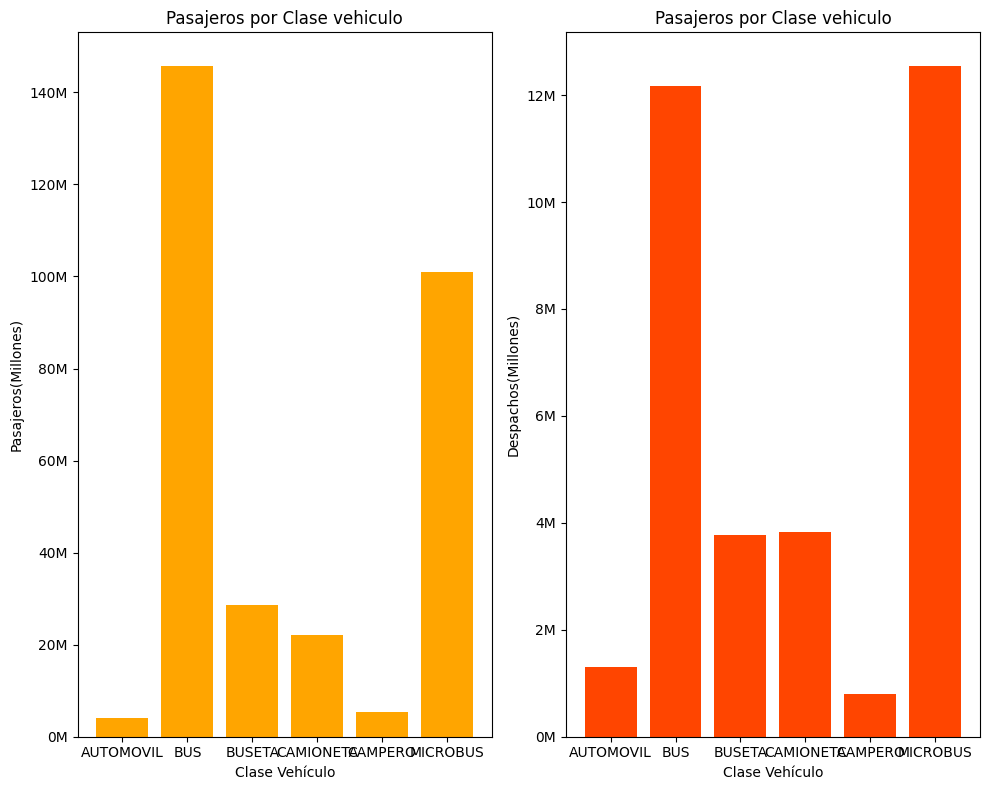

In [26]:
#Ahora se agrupará y presentarán los depachos y pasajeros por tipo de vehículo
data_por_vehiculo = grupo_por_columna(data, 'CLASE_VEHICULO')
#Proporciones por clase de vehículo
data_por_vehiculo['PORCENTAJE_PASAJEROS'] = ((data_por_vehiculo['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_vehiculo['PORCENTAJE_DESPACHOS'] = ((data_por_vehiculo['DESPACHOS'] / total_despachos) * 100).round(2)
data_por_vehiculo['PASAJERO_PROM_POR_VEHÍCULO'] = (data_por_vehiculo['PASAJEROS']/data_por_vehiculo['DESPACHOS']).round(2)
#Presentar resultados en formato de tabla
print('Tabla por clase de vehículo')
print(data_por_vehiculo.sort_values('PASAJEROS', ascending=False))

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.bar(data_por_vehiculo['CLASE_VEHICULO'], data_por_vehiculo['PASAJEROS'], color = 'orange')
plt.xlabel('Clase Vehículo')
plt.ylabel('Pasajeros(Millones)')
plt.title('Pasajeros por Clase vehiculo')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.bar(data_por_vehiculo['CLASE_VEHICULO'], data_por_vehiculo['DESPACHOS'], color = 'orangered')
plt.xlabel('Clase Vehículo')
plt.ylabel('Despachos(Millones)')
plt.title('Pasajeros por Clase vehiculo')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


Si bien la data parece recogerse a través de las terminales de transporte de cada departamento, la clase de vehículos contempla medios de transporte con bajo cupo de pasajeros (Automóvil, Camioneta y Campero), adicional parece que la camioneta ofrece capacidad de pasajeros casi similar a la buseta, según la proporción observada. Es curioso porque implica que son viajes personalizados adquiridos o que son de distancias cortas y que las Empresas de Transporte intermunicipal ofrecen servicio a este nivel de distribución.

Tabla por Nivel de Servicio
         NIVEL_SERVICIO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
1                  LUJO  186240338   21162782                 60.73   
0                BASICO  120322375   13247739                 39.24   
2  PREFERENCIAL DE LUJO      93228       3455                  0.03   

   PORCENTAJE_DESPACHOS  
1                 61.49  
0                 38.50  
2                  0.01  


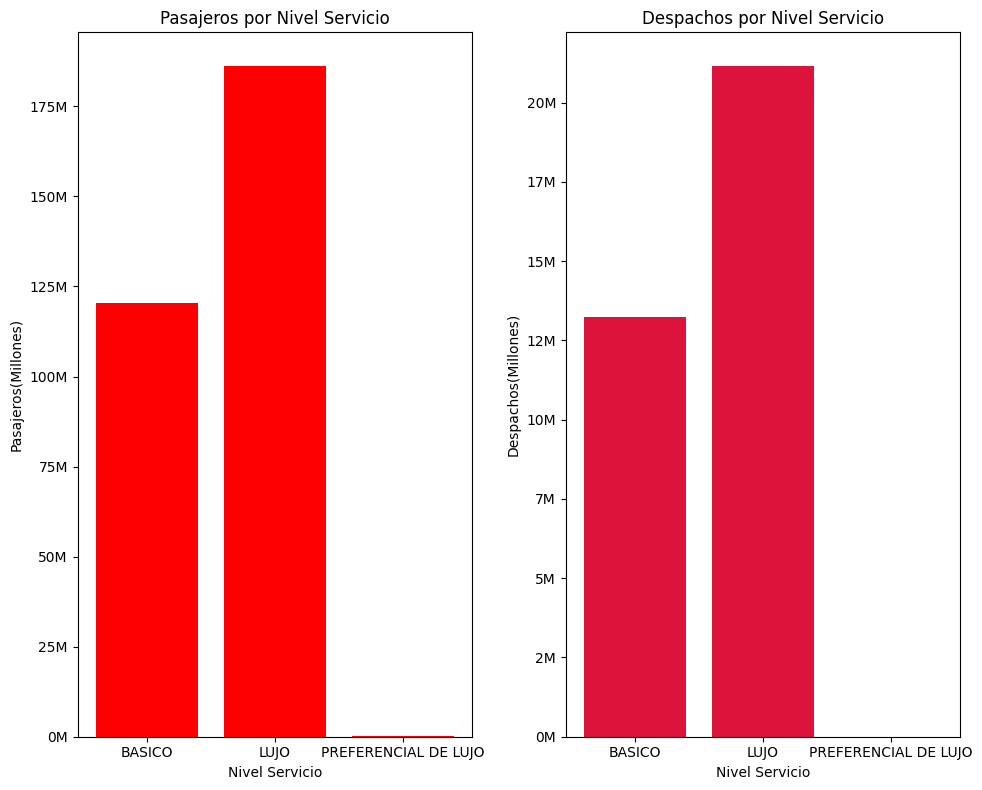

In [27]:
#Ahora se agrupará y presentarán los depachos y pasajeros por tipo de vehículo y se calcularán las proporciones por
#tipo de servicio
data_por_servicio = grupo_por_columna(data, 'NIVEL_SERVICIO')

#Proporciones por nivel de servicio
data_por_servicio['PORCENTAJE_PASAJEROS'] = ((data_por_servicio['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_servicio['PORCENTAJE_DESPACHOS'] = ((data_por_servicio['DESPACHOS'] / total_despachos) * 100).round(2)
print('Tabla por Nivel de Servicio')
print(data_por_servicio.sort_values('PASAJEROS', ascending=False))

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.bar(data_por_servicio['NIVEL_SERVICIO'], data_por_servicio['PASAJEROS'], color = 'red')
plt.xlabel('Nivel Servicio')
plt.ylabel('Pasajeros(Millones)')
plt.title('Pasajeros por Nivel Servicio')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.bar(data_por_servicio['NIVEL_SERVICIO'], data_por_servicio['DESPACHOS'], color = 'crimson')
plt.xlabel('Nivel Servicio')
plt.ylabel('Despachos(Millones)')
plt.title('Despachos por Nivel Servicio')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


In [28]:
#Dado que hay cierto tipo de vehículos cuya carga de pasajeros es más pequeña, se hará una observación de estos en varias
#de sus características
vehiculo_pequeño = grupo_por_columna(data, ['CLASE_VEHICULO', 'NIVEL_SERVICIO'])
vehiculo_pequeño = vehiculo_pequeño.loc[(vehiculo_pequeño['CLASE_VEHICULO'] == 'AUTOMOVIL') | (vehiculo_pequeño['CLASE_VEHICULO'] == 'CAMPERO')]
print('Data carros pequeños')
print(vehiculo_pequeño)

Data carros pequeños
   CLASE_VEHICULO NIVEL_SERVICIO  PASAJEROS  DESPACHOS
0       AUTOMOVIL         BASICO    1753919     538745
1       AUTOMOVIL           LUJO    2361226     761267
11        CAMPERO         BASICO    3788360     509452
12        CAMPERO           LUJO    1500438     291121


Así bien, puede entenderse que el nivel de servicio preferencial de lujo debe ser un servicio adquirido de forma especial por agencia, mientras que lujo puede relacionarse a paquetes de turismo. No hay un diccionario en la data para entender esta referencia, así mismo, no se hace exclusivo de vehículos pequeños y puede observarse sobre los vehículos más grandes también.

Tabla por Departamento de Origen
   DEPARTAMENTO_ORIGEN  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
3         BOGOTÁ, D.C.   50239481    5602218                 16.38   
26     VALLE DEL CAUCA   44018982    5024415                 14.35   
0            ANTIOQUIA   40311134    3948039                 13.15   
5               BOYACÁ   23021442    2876573                  7.51   
21             QUINDÍO   13549916    1933789                  4.42   
22           RISARALDA   14434703    1727637                  4.71   
14               HUILA   13889667    1521018                  4.53   
18              NARIÑO   13751542    1452151                  4.48   
25              TOLIMA   12904747    1413822                  4.21   
6               CALDAS    8209715     913933                  2.68   
19  NORTE DE SANTANDER    6152760     862181                  2.01   
4              BOLÍVAR    8962602     801896                  2.92   
2            ATLÁNTICO    6313899     744637             

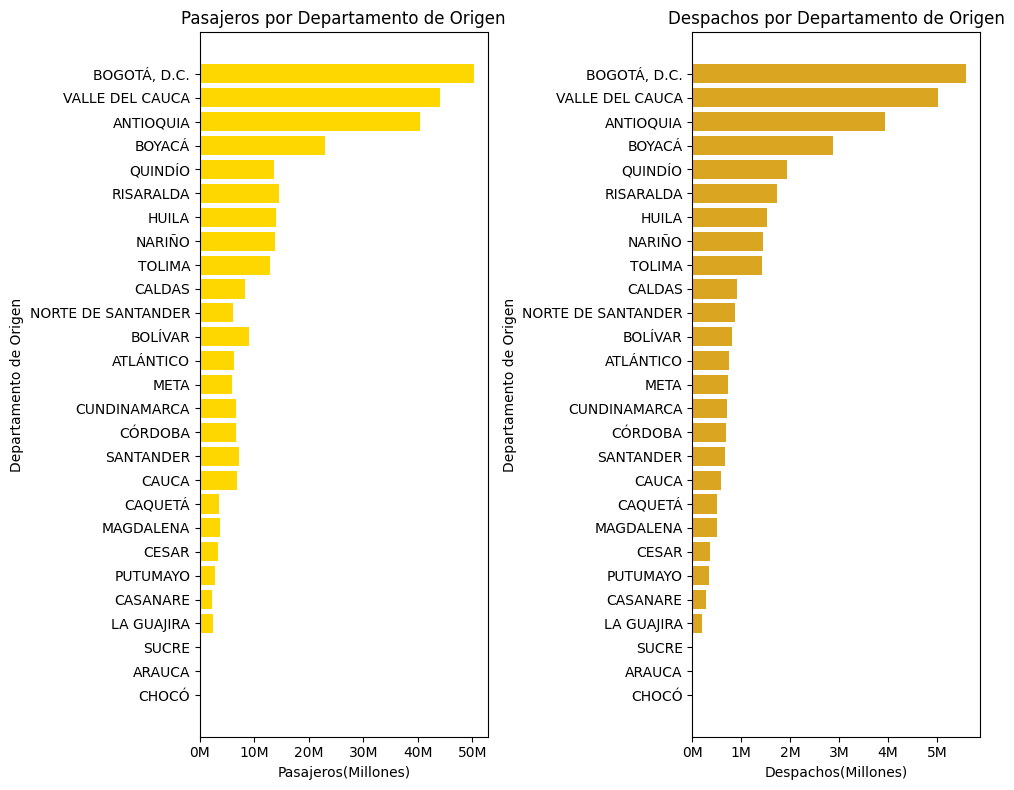

In [29]:
#Ahora se agrupará y presentarán los depachos y pasajeros departamento de origen
data_por_departamento_origen = grupo_por_columna(data, 'DEPARTAMENTO_ORIGEN')

#Proporciones por dapartamento de origne
data_por_departamento_origen['PORCENTAJE_PASAJEROS'] = ((data_por_departamento_origen['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_departamento_origen['PORCENTAJE_DESPACHOS'] = ((data_por_departamento_origen['DESPACHOS'] / total_despachos) * 100).round(2)

#En este caso se ordenarán de mayor a menos los valores por el campo de Despachos de esta forma para que 
#en la gráfica obtengamos este mismo orden
data_por_departamento_origen = data_por_departamento_origen.sort_values('DESPACHOS', ascending=False)

print('Tabla por Departamento de Origen')
print(data_por_departamento_origen)

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.barh(data_por_departamento_origen['DEPARTAMENTO_ORIGEN'], data_por_departamento_origen['PASAJEROS'], color = 'gold')
plt.xlabel('Pasajeros(Millones)')
plt.ylabel('Departamento de Origen')
plt.title('Pasajeros por Departamento de Origen')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.barh(data_por_departamento_origen['DEPARTAMENTO_ORIGEN'], data_por_departamento_origen['DESPACHOS'], color = 'goldenrod')
plt.xlabel('Despachos(Millones)')
plt.ylabel('Departamento de Origen')
plt.title('Despachos por Departamento de Origen')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


Tabla por Departamento de Destino
   DEPARTAMENTO_DESTINO  PASAJEROS  DESPACHOS  PORCENTAJE_PASAJEROS  \
27      VALLE DEL CAUCA   39951353    4253332                 13.03   
0             ANTIOQUIA   39482698    4061132                 12.88   
3          BOGOTÁ, D.C.   33595247    2529098                 10.96   
5                BOYACÁ   22627754    2988096                  7.38   
12         CUNDINAMARCA   17422067    2669804                  5.68   
22              QUINDÍO   13807911    1866075                  4.50   
19               NARIÑO   13747532    1420892                  4.48   
15                HUILA   12096537    1493948                  3.94   
26               TOLIMA   11847575    1529654                  3.86   
6                CALDAS    9581469    1149237                  3.12   
23            RISARALDA    9458498    1282301                  3.08   
24            SANTANDER    9075315     967157                  2.96   
4               BOLÍVAR    8158921     8073

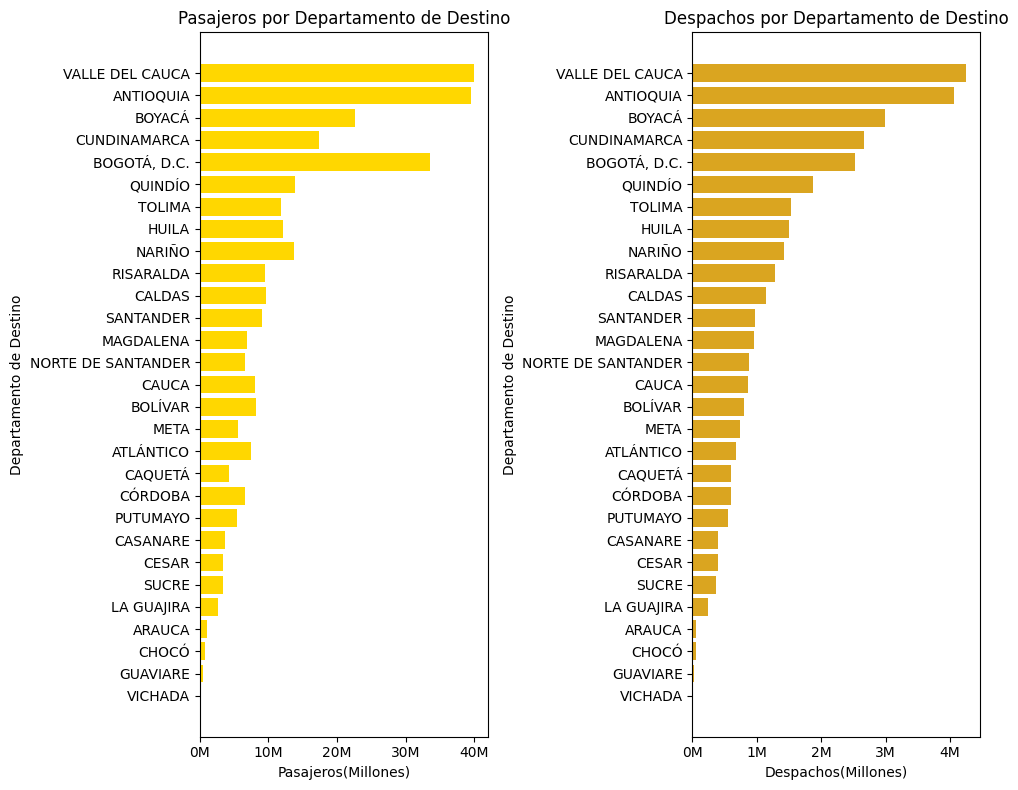

In [30]:
#Ahora se agrupará y presentarán los depachos y pasajeros por departamento de destino
data_por_departamento_destino = grupo_por_columna(data, 'DEPARTAMENTO_DESTINO')

#Proporciones por nivel de destino
data_por_departamento_destino['PORCENTAJE_PASAJEROS'] = ((data_por_departamento_destino['PASAJEROS'] / total_pasajeros) * 100).round(2)
data_por_departamento_destino['PORCENTAJE_DESPACHOS'] = ((data_por_departamento_destino['DESPACHOS'] / total_despachos) * 100).round(2)

#En este caso se ordenarán de mayor a menos los valores por el campo de Despachos de esta forma para que 
#en la gráfica obtengamos este mismo orden
data_por_departamento_destino = data_por_departamento_destino.sort_values('DESPACHOS', ascending=False)

print('Tabla por Departamento de Destino')
print(data_por_departamento_destino.sort_values('PASAJEROS', ascending=False))

#Gráfica 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.barh(data_por_departamento_destino['DEPARTAMENTO_DESTINO'], data_por_departamento_destino['PASAJEROS'], color = 'gold')
plt.xlabel('Pasajeros(Millones)')
plt.ylabel('Departamento de Destino')
plt.title('Pasajeros por Departamento de Destino')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.subplot(1,2,2)
plt.barh(data_por_departamento_destino['DEPARTAMENTO_DESTINO'], data_por_departamento_destino['DESPACHOS'], color = 'goldenrod')
plt.xlabel('Despachos(Millones)')
plt.ylabel('Departamento de Destino')
plt.title('Despachos por Departamento de Destino')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(formato_ejes))

plt.tight_layout()
plt.show()


La vista general entre origenes y destino, ofrece 2 focos de concentración interesantes. Gran cantidad de viajes salen desde la Capital del país y éste mismo se ubica en el 3er puesto de recepción de pasajeros, mientras que el Valle del Cauca, el departamento ubicado más al sur con gran afluencia en las variables, entrega el segundo punto de origenes de viajes y obtiene el primer puesto como destino predilecto de éstos. Seguidos de Antioquia entre los departamentos de renombre.

DEPARTAMENTO_DESTINO  ANTIOQUIA  ARAUCA  ATLÁNTICO  BOGOTÁ, D.C.  BOLÍVAR  \
DEPARTAMENTO_ORIGEN                                                         
ANTIOQUIA               3388299       0      18504         53832    33954   
ARAUCA                        0     951          0          4886        0   
ATLÁNTICO                 20839       0         94         38980   147887   
BOGOTÁ, D.C.              33094   39595      21522          4213    84462   
BOLÍVAR                   22611       0     116982         56332   378461   
BOYACÁ                        3     389          0        510115      170   
CALDAS                    41727       0          2         50099     3061   
CAQUETÁ                    4959       0        952         27386       28   
CASANARE                    155    3071          0         70657        0   
CAUCA                      2265       0          0          8839       11   
CESAR                      5139       0      51724         17158     1208   

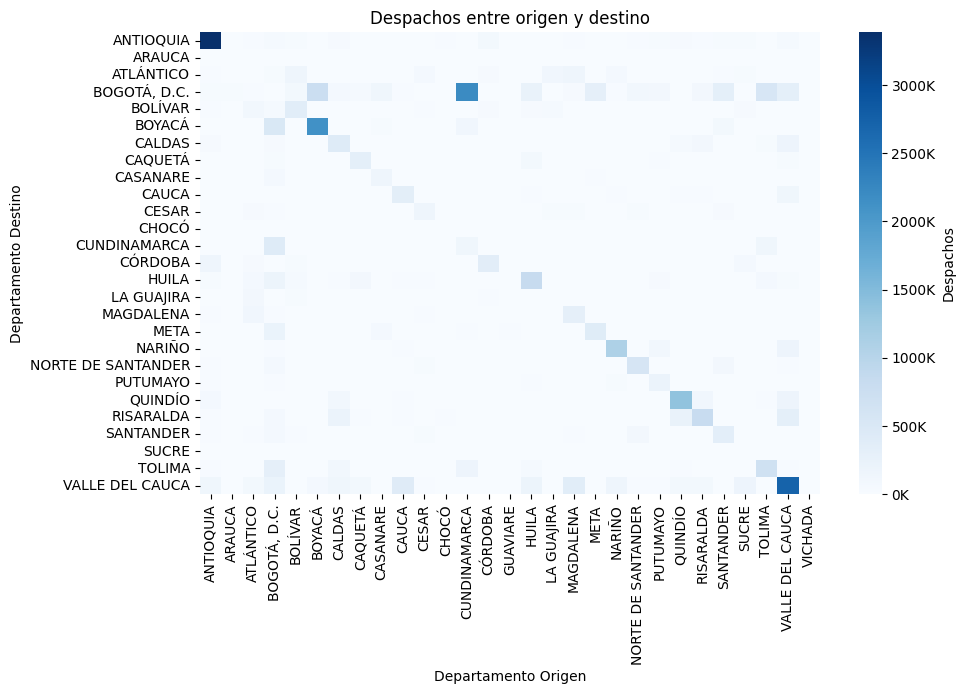

In [31]:
#Despachos entre origen y destino
origen_vs_destino = data.pivot_table(index = 'DEPARTAMENTO_ORIGEN', columns = 'DEPARTAMENTO_DESTINO',
                                      values = 'DESPACHOS', aggfunc='sum', fill_value=0)
print(origen_vs_destino)

#Fromato barra de color para el mapa de calor
def formato_mapa(x, pos):
    return f'{int(x/1e3)}K'
#Gráfica
plt.figure(figsize = (10,6))
sns.heatmap(origen_vs_destino, cmap = 'Blues', cbar_kws={'label': 'Despachos', 'format': FuncFormatter(formato_mapa)})
plt.title('Despachos entre origen y destino')
plt.xlabel('Departamento Origen')
plt.ylabel('Departamento Destino')
plt.show()

Básicamente viendo la distribución del mapa de calor, se explica de mejor forma el comportamiento de destino-origen y el tipo de vehículo implementado, puesto que esta data, fuera de lo esperado para el análisis en cuestión, presenta comportamiento de viajes sobretodo al interior de cada departamento, ubicando gran afluencia de, posiblemente, viajes de trabajo en municipios aledaños (por eso la distribución de horas), viajes de turismo cortos. O casos como el de Bogotá D.C. requerimientos, vueltas personales y de salud de comunidades del departamento de Cundinamarca que deben ir a la capital a suplir sus necesidades, entre otras razones más por explorar.

In [32]:
#Dada la distribución de los departamentos, es interesante observar la cantidad de destinos que estos realizan
dept_origen_destinos_unicos = grupo_por_columna(data,'DEPARTAMENTO_ORIGEN')
dept_origen_destinos_unicos['Municipios Origen Únicos'] = data.groupby('DEPARTAMENTO_ORIGEN')['MUNICIPIO_ORIGEN'].nunique().reset_index(drop=True)
dept_origen_destinos_unicos['Destinos Únicos'] = data.groupby('DEPARTAMENTO_ORIGEN')['DEPARTAMENTO_DESTINO'].nunique().reset_index(drop=True)
dept_origen_destinos_unicos['Municipios Destino Únicos'] = data.groupby('DEPARTAMENTO_ORIGEN')['MUNICIPIO_DESTINO'].nunique().reset_index(drop=True)
print(dept_origen_destinos_unicos.sort_values('DESPACHOS', ascending=False))

   DEPARTAMENTO_ORIGEN  PASAJEROS  DESPACHOS  Municipios Origen Únicos  \
3         BOGOTÁ, D.C.   50239481    5602218                         1   
26     VALLE DEL CAUCA   44018982    5024415                        16   
0            ANTIOQUIA   40311134    3948039                        11   
5               BOYACÁ   23021442    2876573                        71   
21             QUINDÍO   13549916    1933789                         2   
22           RISARALDA   14434703    1727637                        11   
14               HUILA   13889667    1521018                        19   
18              NARIÑO   13751542    1452151                        10   
25              TOLIMA   12904747    1413822                        30   
6               CALDAS    8209715     913933                        16   
19  NORTE DE SANTANDER    6152760     862181                         6   
4              BOLÍVAR    8962602     801896                         3   
2            ATLÁNTICO    6313899     

Sin embargo, la data general ofrece que los departamento principales distribuyen viajes y pasajeros a casi todos los departamentos posibles, lo cual hace que se deba implementar otras opciones de exploración para dar la explicación concreta del comportamiento de viajes en este conjunto de datos.

In [33]:
#Y en el caso contrario también
dept_destino_origen_unico = grupo_por_columna(data,'DEPARTAMENTO_DESTINO')
dept_destino_origen_unico['Origenes Únicos'] = data.groupby('DEPARTAMENTO_DESTINO')['DEPARTAMENTO_ORIGEN'].nunique().reset_index(drop=True)
print(dept_destino_origen_unico.sort_values('DESPACHOS', ascending=False))


   DEPARTAMENTO_DESTINO  PASAJEROS  DESPACHOS  Origenes Únicos
27      VALLE DEL CAUCA   39951353    4253332               20
0             ANTIOQUIA   39482698    4061132               23
5                BOYACÁ   22627754    2988096               15
12         CUNDINAMARCA   17422067    2669804               12
3          BOGOTÁ, D.C.   33595247    2529098               27
22              QUINDÍO   13807911    1866075               12
26               TOLIMA   11847575    1529654               17
15                HUILA   12096537    1493948               17
19               NARIÑO   13747532    1420892               12
23            RISARALDA    9458498    1282301               16
6                CALDAS    9581469    1149237               22
24            SANTANDER    9075315     967157               17
17            MAGDALENA    6864499     957287               14
20   NORTE DE SANTANDER    6512388     878259               19
9                 CAUCA    7969625     862324          

In [34]:
mun_destino_origen_unico = grupo_por_columna(data,'MUNICIPIO_DESTINO')
mun_destino_origen_unico['Origenes Únicos'] = data.groupby('MUNICIPIO_DESTINO')['MUNICIPIO_ORIGEN'].nunique().reset_index(drop=True)
print(mun_destino_origen_unico.sort_values('DESPACHOS', ascending=False))

       MUNICIPIO_DESTINO  PASAJEROS  DESPACHOS  Origenes Únicos
79          BOGOTÁ, D.C.   33595247    2529098              192
609     SANTIAGO DE CALI   17537540    1434982               73
413                NEIVA    5456958     652935               49
634             SOGAMOSO    6155093     628878               39
600  SANTA ROSA DE CABAL    2316481     578015                1
..                   ...        ...        ...              ...
359       LÓPEZ DE MICAY         12          1                1
416              NIMAIMA          4          1                1
263             GUACHENÉ          6          1                1
366              MALLAMA          8          1                1
674             TIBASOSA          1          1                1

[758 rows x 4 columns]


In [35]:
mun_origen_destino_unico = grupo_por_columna(data,'MUNICIPIO_ORIGEN')
mun_origen_destino_unico['Destinos Únicos'] = data.groupby('MUNICIPIO_ORIGEN')['MUNICIPIO_DESTINO'].nunique().reset_index(drop=True)
print(mun_origen_destino_unico.sort_values('DESPACHOS', ascending=False))

     MUNICIPIO_ORIGEN  PASAJEROS  DESPACHOS  Destinos Únicos
35       BOGOTÁ, D.C.   50239481    5602218              299
261  SANTIAGO DE CALI   32967550    3745534               93
152          MEDELLÍN   35314776    2990607              170
19            ARMENIA   13556295    1934309               41
196           PEREIRA   14431424    1727110               51
..                ...        ...        ...              ...
125       JESÚS MARÍA         23          1                1
56        CHIMICHAGUA         10          1                1
290              TOTA         20          1                1
52             CERETÉ         17          1                1
315     ZONA BANANERA          6          1                1

[316 rows x 4 columns]


### **Observación General**

La data recolectada, si bien menciona que se origina desde cada Terminal registrada, puede ahondarse en dar mayor claridad sobre el nivel de servicio mencionado, y gracias a data de otras fuentes podría darse explicaciones más profundas en el asunto. Así mismo, la concentración de viajes al interior de cada departamento, puedría considerar poder ampliar las características de registro de información, conociendo el tipo de viaje realizado en ciertos pasajeros. Es un conjunto apto para conocer el comportamiento de pasajeros, y el fin principal de análisis no hay información explícita sobre las compañías que registraron la data, para dar una mayor relación en la partipación de éstas, la recuperación de sus servicios desde la pandemia y demás características para indagar en el portafolio ofrecido.

In [36]:
# Nombre del archivo Excel en el que se guardarán las hojas
#nombre_archivo_excel = 'TablasPruebaPinbusDC.xlsx'

# Crear un objeto ExcelWriter para guardar los DataFrames en un archivo Excel
#writer = pd.ExcelWriter(nombre_archivo_excel, engine='xlsxwriter')

# Escribir cada DataFrame en una hoja separada en el archivo Excel
#data_agrupada.to_excel(writer, sheet_name='Tendencia y variación Mensual', index=False)
#tendencia_anual_por_departamento.to_excel(writer, sheet_name='Tendencia Anual Departamento', index=False)
#tendencia_anual_por_departamento_mes.to_excel(writer, sheet_name='Tendencia Mensual Departamento', index=False)
#data_por_hora_despacho.to_excel(writer, sheet_name='Desp&Pas Hora Despacho', index=False)
#data_por_vehiculo.to_excel(writer, sheet_name='Desp6Pas Tipo Vehiculo', index=False)
#data_por_servicio.to_excel(writer, sheet_name='Desp6Pas Nivel de Servicio', index=False)
#data_por_departamento_origen.to_excel(writer, sheet_name='Des&Pas Departamento Origen', index=False)
#data_por_departamento_destino.to_excel(writer, sheet_name='Desp&Pas Departamento Destino', index=False)
#origen_vs_destino.to_excel(writer, sheet_name='Desp&Pas Origen-Destino', index=False)
#dept_origen_destinos_unicos.to_excel(writer, sheet_name='Destinos Unicos por Origen', index=False)
#dept_destino_origen_unico.to_excel(writer, sheet_name='Origen Unico por Destino', index=False)

# Guardar el archivo Excel
#writer.close()

#print("DataFrames guardados en el archivo Excel con hojas separadas.")
